<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo">
</center>

# Understanding  Generative Adversarial Networks GANs

Estimated time needed: **35** minutes

In this lab, we will focus on simulated data to better understand Generative Adversarial Networks (GANs).


## **Table of Contents**

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
    </li>
    <li>
        <a href="https://#Background">Background</a>
    </li>
    <li>
        <a href="https://#Toy Data">Toy Data</a>
    </li>
    <li>
        <a href="https://#The Generator">The Generator</a>
    </li>
    <li>
        <a href="https://#The Discriminator">The Discriminator</a>
    </li>
        <li>
        <a href="https://#The Loss Function GANs (Optional)">The Loss Function GANs (Optional)</a>
            <ol>
            <li><a href="https://#Discriminator">Discriminator</a></li>
            <li><a href="https://#Generator">Generator</a></li>
        </ol>
        </li>
    <li>
        <a href="https://#Training GANs">Training GANs</a>
         <ol>
            <li><a href="https://#Training Generator">Training Generator</a></li>
             <li><a href="https://#Training Discriminator">Training Discriminator</a></li>
        </ol>
    </li>


## Objectives

After completing this lab, you will be able to:

*   **Understand** the original formulation of GANs, and their two separately trained networks: Generator and Discriminator
*   **Implement** GANs on simulated and real datasets


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.
*   [`keras`](https://keras.io/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for loading datasets.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!pip3 install --upgrade tensorflow` in the cell below.


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [2]:
#!pip3 install --upgrade tensorflow

### Importing Required Libraries


In [3]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
import time
from tensorflow.keras import models
from tqdm import tqdm

2.11.1


### Helper function


In [4]:
def plot_distribution(real_data,generated_data,discriminator=None,density=True):
    
    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')
    
    if discriminator:
        max_=np.max([int(real_data.numpy().max()),int(generated_data.numpy().max())])
        min_=np.min([int(real_data.numpy().min()),int(generated_data.numpy().min())])
        x=np.linspace(min_, max_, 1000).reshape(-1,1)
        plt.plot(x,tf.math.sigmoid(discriminator(x,training=False).numpy()),label='discriminator',color='k')
        plt.plot(x,0.5*np.ones(x.shape),label='0.5',color='b')
        plt.xlabel('x')
        
    plt.legend()
    plt.show()

## Background


Generative Adversarial Networks (GANs) are generative models that convert random samples of one distribution into another distribution. They have several applications, like the following:

*   Generate Examples for Image Datasets
*   Generate Photographs of Human Faces
*   Generate Realistic Photographs
*   Generate Cartoon Characters
*   Image-to-Image Translation
*   Text-to-Image Translation
*   Face Frontal View Generation
*   Generate New Human Poses
*   Face Aging
*   Photo Blending
*   Super Resolution
*   Photo Inpainting
*   Clothing Translation
*   Video Prediction

In this lab, we will use a toy example to help understand the basic theoretical principles behind GANs. The original form of GANs consisted of a discriminator and a generator; let's use the analogy of a currency forger and the police.

The Generator is the currency forger, and the output is the counterfeit, for example, a 100-dollar bill. The discriminator is analogous to the police taking the counterfeit and trying to determine if it's real by comparing it to a real $100 bill. In real life, if the counterfeit is easy to detect, the forger will adapt; conversely, the police will also improve; GANs emulate this game of cat and mouse.

What makes GANs interesting is that the discriminator and generator continuously improve each other by a well-formulated cost function that backpropagates the errors. GANs are a family of algorithms that use *learning by comparison*. In the lab, we will review the original formulation and use a simulated dataset. We will also point you to some more advanced methods and issues you will encounter with the real datasets for the next lab.


<h2 id="about_dataset">Toy Data</h2>

Consider the following data, $\mathbf{x}$, that is normally distributed $\mathbf{x} \sim \mathcal{N}(\mathbf{x}|10,1) $ with a mean of 10 and a standard deviation of 1. Now we would like to randomly sample data from this distribution.


In [5]:
mean = [10]
cov = [[1]]
X = tf.random.normal((5000,1),mean=10,stddev=1.0)

print("mean:",np.mean(X))
print("standard deviation:",np.std(X))

mean: 9.994719
standard deviation: 0.9988733


We also have the data sample, z, which is also normally distributed $\mathbf{z} \sim \mathcal{N}(\mathbf{z}|0,2) $, with mean of 0 and a standard deviation of 2:


In [6]:
Z = tf.random.normal((5000,1),mean=0,stddev=2)

In [7]:
print("mean:",np.mean(Z))
print("standard deviation:",np.std(Z))

mean: 0.037705466
standard deviation: 2.0293598


Let's compare the two distributions:


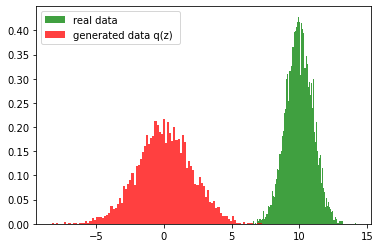

In [8]:
plot_distribution(X,Z,discriminator=None,density=True)

Let's create our first generative model by adding 10 to every sample of $z$. We will call the result $\hat{\mathbf{x}}$  as it's an approximation of $\mathbf{x}$. It is not too difficult to show that $\hat{\mathbf{x}} \sim \mathcal{N}(\mathbf{x}|10,1)$.


In [9]:
Xhat=Z+10

We see that the mean and standard deviation are almost identical


In [10]:
print("mean:",np.mean(Xhat))
print("standard deviation:",np.std(Xhat))

mean: 10.037705
standard deviation: 2.0293598


Similarly for the histograms


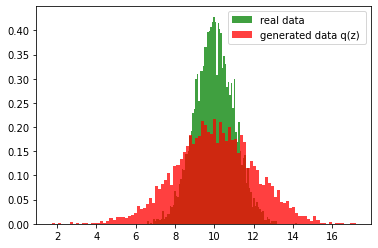

In [11]:
plot_distribution(X,Xhat,discriminator=None,density=True)

In the case above, since we just add 10 to the latent variable $z$, we transform $z$ using a deterministic function. We can call this an implicit generative model.


## The Generator


There are two networks involved in a GAN, the Generator and the Discriminator. Let's understand the Generator network first.

The Generator is a neural network denoted by $G$; the idea is that a neural network can approximate any function (by the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)), so you should be able to generate data samples from any type of distribution.

Our goal is to convert the samples, $\mathbf{z}$, to one that approximates $\hat{\mathbf{x}}$,  i.e $\hat{\mathbf{x}}=G(\mathbf{z})$. Let's build a simple Generator $G(\mathbf{z})=\mathbf{W}^{T}\mathbf{z}+\mathbf{b} $ using Keras.

The following is a function that outputs a generator using Kera's Sequential model object.


In [12]:
def make_generator_model():
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1))
    return generator

We can use the Generator to convert $\mathbf{z}$ and make a prediction $\hat{\mathbf{x}}$, and display the histogram of the distributions of $\hat{\mathbf{x}}$ and $\mathbf{x}$. As the model is not trained, the trained distributions are quite different:


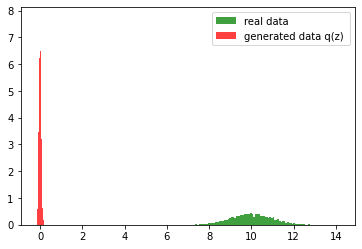

In [13]:
generator=make_generator_model()

Xhat = generator(Z, training=False)
plot_distribution(real_data=X,generated_data=Xhat)

We will discuss the use of the parameter `training=False` later on.


## The Discriminator


The discriminator $D(\mathbf{x})$ is a neural network that learns to distinguish between actual and generated samples. The simplest Discriminator is a simple logistic regression function. Let's create a discriminator in Keras with one Dense layer; we leave the logistic function out as it will be incorporated in the cost function, which is the convention in Keras.


In [14]:
def make_discriminator_model():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=make_discriminator_model()

The discriminator and generator are randomly initialized, but we can plot the output of each and compare it to the true data distribution, with the generated data in red and the real data in green, and the logistic function as a function of the x axis. We also include the threshold. If the output of the logistic function is less than 0.5, the sample is classified as generated data; conversely, if the output is greater than 0.5, the sample will be classified as data that came from the real distribution.


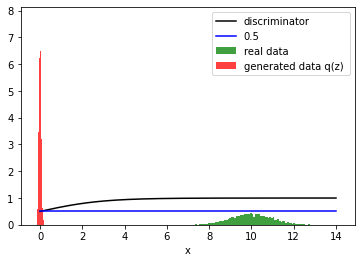

In [15]:
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator)

Applying the sigmoid function to the discriminator output, we get the probabilites that the samples belong to the real distribution. We can count the number of true samples that the discriminator correctly classifies.

For the real data, the discriminator successfully assigns a probability greater than 0.5 for all 5000 samples:


In [16]:
py_x=tf.math.sigmoid(discriminator(X,training=False))
np.sum(py_x>0.5)

5000

For the generated data, only 1425 out of the 5000 samples are classified as having more than 50% chance of coming from the real distribution.


In [17]:
py_x=discriminator(Xhat)
np.sum(py_x>0.5)

0

We can also use the follwoing to find the average value of the sigmoid function for all the samples.


In [18]:
def get_accuracy(X,Xhat):
    total=0
    py_x=tf.math.sigmoid(discriminator(X,training=False))
    total=np.mean(py_x)
    py_x=tf.math.sigmoid(discriminator(Xhat,training=False))
    total+=np.mean(py_x)
    return total/2

In [19]:
get_accuracy(X,Xhat)

0.7492607831954956

In many cases, we can instead study the difference in the distribution; in this case, the discriminator is called a <a href='https://arxiv.org/pdf/2107.06700.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01'>Critic</a>, a real-valued function.


## The Loss Fuction  GANs (optional)

GANs convert an unsupervised learning problem to a supervised one. Instead of formulating the problem like a two-player minimax game with a value function like in <a href=https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01 >\[1]</a>, we can treat the problem of maximizing the familiar log-likelihood of the logistic function analogous to minimizing the cross-entropy loss, then incorporate the generator and discriminator.

### Discriminator

In order to train the GANS, we start off with standard maximization of the likelihood for the discriminator for the standard dataset $\mathcal{D}={{(x\_1, y\_1), ..., (x_N, y_N)}}$:

$$V(D)=\sum\_{n=1}^N \left( y_n \ln(D(\mathbf{x}\_n))+(1-y_n) \ln(1-D(\mathbf{x}\_n))\right)$$

Where $y=1$ for samples from the true distribution and $y=0$ for samples from the generator. The goal is to maximize this term with respect to $D$:

$$max\_{D}(V(D))$$


To also incorporate the generated samples, we augment the right side of the equation with the generated $k$th sample $\hat{\mathbf{x}}\_k$. As they are not part of the dataset $k \notin \mathcal{D} $, we have to include a second summation where $y=0$. Finally, combining the cases of $y=1$ and $y=0$, we get:

$$V(D)=\sum\_{ n	\in \mathcal{D}}  \ln(D(\mathbf{x}*n))+\sum*{k 	\notin \mathcal{D}} \ln(1-D(\hat{\mathbf{x}}\_k) ) $$


### Generator

For the generator we simply replace $\hat{\mathbf{x}}\_k$ with the $G(\mathbf{z}\_k)$ .

$$V(G,D)=\sum\_{n	\in \mathcal{D}} \ln(D(\mathbf{x}*n))+\sum*{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}\_k))) $$

As this is a density estimation problem, it is common to replace the summation with the expected value like in <a href=https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01 >\[1]</a>. We replace the summations with an expectation where $p(\mathbf{x})$ is the true distribution and $p(\mathbf{z})$ is the distribution of $\mathbf{z}$.

$$V(D,G)=\mathbb{E}*{x\sim p(\mathbf{x})} \ln(D(\mathbf{x})) + \mathbb{E}*{\mathbf{z} \sim p(\mathbf{z})} \ln(1-D(G(\mathbf{z}) )) $$

As we are trying to trick the discriminator, we would like to find a $G$ that minimize the above expression, such as:

$$min\_{G} max\_{D} V(D,G)$$


## Training GANS

### Training Generator

GANs are quite difficult to train, even for a simple example. Let's start off with training the generator in practice.

$log(1 − D(G(\mathbf{z})))$ is difficult to work with as $D(G(\mathbf{z}))$ is near one or zero for the first few iterations. This is because the generator is not yet properly trained, and the discriminator can easily distinguish between the generated and actual samples. Therefore we maximize $log(D(G(\mathbf{z}\_k)) )$.

Although the output of the generator passes through the discriminator, we do not update the generator in the optimization step, hence we set the parameter `training=False` in the actual training steps.

Instead of maximizing the term, we can take the negative and minimize it. The resultant expression can be calculated in Keras using the cross-entropy loss where all the target values are set to one:

$$\sum\_{k 	\notin \mathcal{D}} log(1 - D(G(\mathbf{z}\_k)) )$$


In [20]:
# This method returns a helper function to compute crossentropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

### Training Discriminator

We can also use the cross-entropy to train the discriminator; we simply multiply $V(G,D)$ by a negative number, set $y=0$ for the generated values and $y=1$ for the real values. We do not update the generator parameters.

$$V(G)=\sum\_{n	\in \mathcal{D}} (\ln(D(\mathbf{x}*n)))+\sum*{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}\_k) )) $$


The first term is the real loss and the second is the fake loss in Keras.


In [21]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

We create the optimizer for the discriminator and generator:


In [22]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)

discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)


We now train the model; as the dataset is small, we will use batch gradient descent.

For each iteration we will generate $M$ real examples ${\mathbf{x}*{1}, ...,\mathbf{x}*{M}}$, these are from the generating distribution $p(\mathbf{x})$. This would be our actual dataset if we used real data.

We will then generate a sample batch of $M$ noise samples ${\mathbf{z}*{1}, ...,\mathbf{z}*{M}}$ from noise prior $p(\mathbf{z})$ and convert the result to a generated image using the generator ${\hat{\mathbf{x}}*{1}, ...,\hat{\mathbf{x}}*{M}}$.

We determine the output of the discriminator for both the real and generated samples. We calculate the loss and then update the discriminator and generator through their respective stochastic gradients.


The convergence of GAN training is a subject in itself. But let's explore a method that works for this simple dataset. Intuitively, we know that if our generated data is identical to our actual data, the probability of correctly classifying is random. Therefore if the generated and actual data are of equal proportion, $D(\mathbf{x}\_n)=0.5$ and $D(\hat{\mathbf{x}}\_n)=0.5$.

We only display iterations where the average discriminator output gets closer to 50% for both the generated data and actual data.


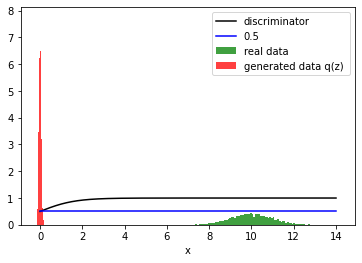

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0
INFO:tensorflow:Assets written to: generator/assets
INFO:tensorflow:Assets written to: discriminator/assets
0.7372902631759644


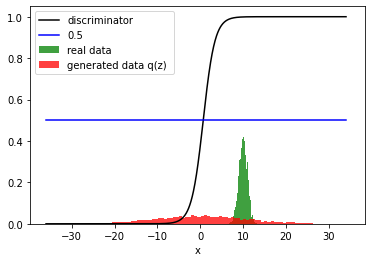

  5%|▌         | 1/20 [00:09<03:00,  9.48s/it]

epoch 0
INFO:tensorflow:Assets written to: generator/assets
INFO:tensorflow:Assets written to: discriminator/assets
0.6127753257751465


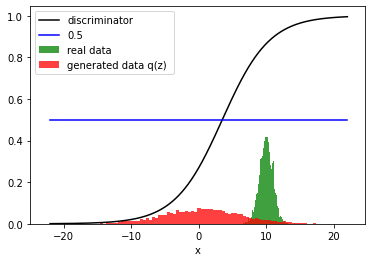

 10%|█         | 2/20 [00:17<02:41,  8.96s/it]

epoch 1


 30%|███       | 6/20 [00:18<00:32,  2.32s/it]

INFO:tensorflow:Assets written to: generator/assets
INFO:tensorflow:Assets written to: discriminator/assets
0.5391600131988525


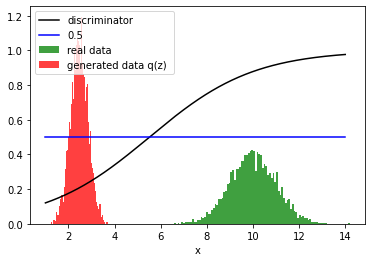

 35%|███▌      | 7/20 [00:28<01:02,  4.84s/it]

epoch 6
INFO:tensorflow:Assets written to: generator/assets
INFO:tensorflow:Assets written to: discriminator/assets
0.5301821231842041


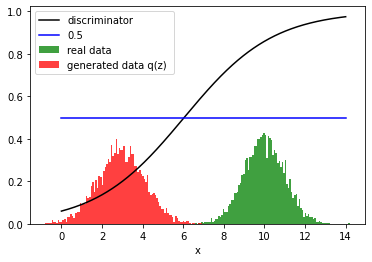

 40%|████      | 8/20 [00:37<01:13,  6.14s/it]

epoch 7


 50%|█████     | 10/20 [00:38<00:31,  3.12s/it]

INFO:tensorflow:Assets written to: generator/assets
INFO:tensorflow:Assets written to: discriminator/assets
0.49264761805534363


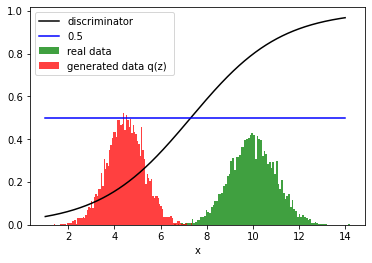

 60%|██████    | 12/20 [00:46<00:25,  3.14s/it]

epoch 10


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


In [23]:
#paramters for trainng 
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100 


#discrimator and gernerator 
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the  stander deviation, you get better results 
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample 
        xhat = generator(z, training=True)
        #the output of the discriminator for real data 
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each 
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  # Save and display the generator and discriminator if the performance increases 
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        generator.save('generator')
        discriminator.save('discriminator')
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

For more on training GANs check out the following <a href="https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01">blog</a>. We can display the best performing model


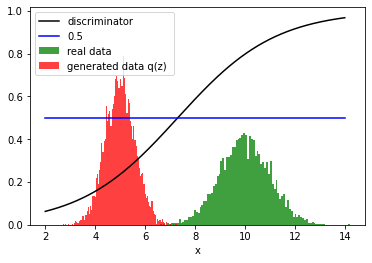

In [24]:
generator=make_generator_model()
generator= models.load_model('generator')
xhat=generator(z)
discriminator=models.load_model('discriminator')
plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )

We usually use this version of TensorFlow for the rest of the course, so don't forget to downgrade


In [25]:
%%capture
!pip install --upgrade tensorflow==1.14.0

**Thank you for completing this lab!**

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>

## Change Log

Change Log

| Date (YYYY-MM-DD) | Version | Changed By         | Change Description |
| ----------------- | ------- | ------------------ | ------------------ |
| 2022-06-31        | 0.1     | Joseph Santarcange | Created lab        |
| 2022-09-09        | 0.1     | Steve Hord         | QA pass edits      |

## <h3 align="center"> © IBM Corporation 2022. All rights reserved. <h3/>
